# Super-Resolution Convolutional Neural Network
> In this project, it will show CNN model that can enhance the resolution of image using Convolutional Neural Network. The topic is from the paper "Image Super-Resolution Using Deep Convolutional Networks", presented in ECCV 2014.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Vision, Tensorflow-Keras]
- image: images/srcnn_result.png

[Image Super-Resolution Using Deep Convolutional Network](https://arxiv.org/abs/1501.00092) (Dong et al. 2014) introduced the Super-Resolution Convolutional Neural Network (SR-CNN for short) that can enhance the resolution of original image. SR-CNN is deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution image. In this post, we will dig into the basic principles of SR-CNN, and implement it.

## Required Packages

In [1]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import h5py
from PIL import Image

## Version check

In [2]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.19.2
Pandas: 1.3.4
OpenCV: 4.0.1
Tensorflow: 2.3.0
Matplotlib: 3.4.3
Scikit-Image: 0.18.3


## Metric Functions
Actually, when we saw the raw image, we cannot make sure that this image is whether high resolution image or not. There are several metrics to measure image quality, and we will use

- [Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) (PSNR)
- Mean Squared Error (MSE)
- [Structural Similarity](https://en.wikipedia.org/wiki/Structural_similarity) (SSIM)

Defined in Wikipedia, **PSNR** is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. As you can see the term "Ratio" in words, it is usually expressed in terms of logarithmic decibel (dB) scale, and has following relation,

$$ \text{MSE} = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1}[I(i, j) - K(i, j)]^2 $$

Here, $I$ is monochrome image and $K$ is its noisy approximation. Expressed in dB scale,

$$ \begin{aligned} PSNR &= 10 \cdot \log_{10} \Big(\frac{\text{MAX}_I^2}{\text{MSE}}\Big) \\ &= 20 \cdot \log_{10}(\text{MAX}_I) - 10 \cdot \log_{10}(\text{MSE}) \end{aligned} $$

From the formula, Image quality will be better if the PSNR value is high, since maximum pixel value is much higher than MSE value.

And **SSIM** is a method for predicting the perceived quality, and it is used for measuring the similarity between two images. If this value is close to 1, then two images are identical. Otherwise, two images will be totally different. Think about it that we can increase PSNR while maintaining the SSIM. That maybe works in CNN. So it is required to define these metrics.

### Peak Signal-to-Noise Ratio (PSNR)

> Note: OpenCV has psnr method (`cv2.psnr`), but we implement this manually here

In [13]:
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(np.max(ref_data) / rmse)

### Mean Squared Error (MSE)

In [14]:
def mse(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= float(target_data.shape[0] * target_data.shape[1])
    return err

### Strucutural Similarity
Actually, this metrics is already implemented in skimage.

In [15]:
from skimage.metrics import structural_similarity as ssim

After we defined our metrics for measuring image quality, we need to combine whole metrics in one metric.

In [16]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

## Prepare distorted images via resizing
We need to check the functionality of our metric function, and it requires target and reference image to compare. Thankfully, the original paper published its source code (implemented in Matlab and Caffe) and dataset image in [here](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html). So we can use it. For the convenience, I downloaded image folder(named `Train` and `Test`) into new directory (`dataset\SRCNN_dataset`)

Then how can we make distorted image from the raw data. It is just simple. After resize down the original image, resize it again to previous width height, then the resolution will be lower since the pixel information may loss during resize.

In [71]:
def prepare_images(path, index, factor):
    # Loop through the files in the directory
    for file in os.listdir(path + '/' + index):
        
        if file != '00049.png' : # choose 00000.png, 00024.png, 00049.png from each folder
            continue

        image = cv2.imread(path + '/' + index + '/' + file)
        
        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # Resize down the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # # Resize up the image
        # image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Save the image
        try:
            os.listdir(path + '/resized/factor_' + str(factor) + '/')
        except:
            os.makedirs(path + '/resized/factor_' + str(factor) + '/')
            
        cv2.imwrite(path + ('/resized/factor_' + str(factor) + '/{}').format(index + '_' + file), image)

In [72]:
for file in os.listdir('G:/LQ_test'):
    prepare_images('G:/LQ_test', file, 4)

In [81]:
def prepare_images(path, index):
    # Loop through the files in the directory
    for file in os.listdir(path + '/' + index):
        
        if file != '00000.png' : # choose 00000.png, 00024.png, 00049.png from each folder
            continue

        image = cv2.imread(path + '/' + index + '/' + file)
        cv2.imwrite(path + ('/HQ' + '/{}').format(index + '_' + file), image)

In [82]:
for file in os.listdir('G:/GT_test'):
    prepare_images('G:/GT_test', file)

Let's see it works.

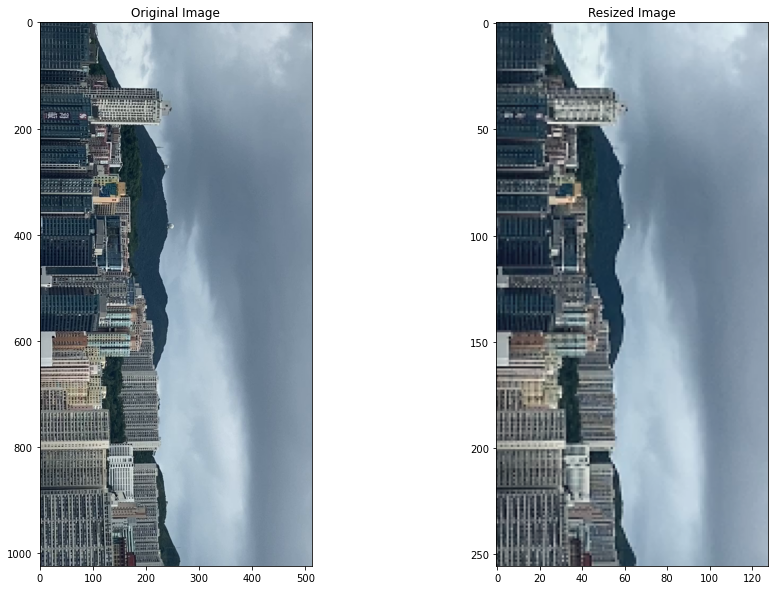

In [85]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('G:/Train_dataset/HR/000_00000.png'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('G:/Train_dataset/LR/downscale_4/000_00000.png'))
ax[1].title.set_text('Resized Image')
plt.show()

Maybe you can see right image is slightly blurred compared with left image. If we cannot make sure, just use metric function that defined previously.

In [88]:
target = cv2.imread('G:/Train_dataset/HR/000_00000.png')
ref = cv2.imread('G:/Train_dataset/LR/downscale_4/000_00000.png')
ref = cv2.resize(ref, (512, 1024), interpolation=cv2.INTER_CUBIC)
metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

PSNR: 21.223408181745178
MSE: 1471.840663909912
SSIM: 0.7275732732672674


Actually, there are several transformations for data augmentation, like random crop. [Someone](https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py) made a dataset with h5 format throught script, so we borrow it from there.

In [4]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build train dataset
import h5py

names = sorted(os.listdir('G:/Train_dataset/HR/'))

data = []
label = []

for name in names:
    fpath = 'G:/Train_dataset/HR/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_shape = hr_img.shape
    
    fpath = 'G:/Train_dataset/LR/downscale_4/' + name # use the downscale_4 LR dataset
    lr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    lr_img = cv2.resize(lr_img, (hr_shape[1], hr_shape[0]), interpolation=cv2.INTER_CUBIC)
    

    hr_patch = hr_img.astype(np.float32) / 255. # normalize value from [0,255] to [0,1]
    lr_patch = lr_img.astype(np.float32) / 255.

    label.append(hr_patch)
    data.append(lr_patch)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

print(data.shape)
print(label.shape)

(1500, 256, 128, 3)
(1500, 1024, 512, 3)


In [5]:
with h5py.File('G:/Train_dataset/train_downscale_4.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [6]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build test dataset

names = sorted(os.listdir('G:/Test_dataset/HR/'))
nums = len(names)

data_test = []
label_test = []

for i, name in enumerate(names):
    fpath = 'G:/Test_dataset/HR/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_shape = hr_img.shape
    
    fpath = 'G:/Test_dataset/LR/downscale_4/' + name
    lr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    lr_img = cv2.resize(lr_img, (hr_shape[1], hr_shape[0]), interpolation=cv2.INTER_CUBIC)
    
    hr_patch = hr_img.astype(np.float32) / 255. # normalize value from [0,255] to [0,1]
    lr_patch = lr_img.astype(np.float32) / 255.

    label_test.append(hr_patch)
    data_test.append(lr_patch)

data_test = np.array(data_test, dtype=np.float32)
label_test = np.array(label_test, dtype=np.float32)

print(data_test.shape)
print(label_test.shape)

(150, 256, 128, 3)
(150, 1024, 512, 3)


In [7]:
with h5py.File('G:/Test_dataset/test_downscale_4.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

## Build SR-CNN Model
We prepared our dataset into h5 format. We also need to build SR-CNN model using tensorflow. You already know that keras framework is integrated in tensorflow v2.x. So we can implement it with tensorflow-keras model. In this case, we will build it with sequential model.

In [3]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     strides=1,
                                     padding='same',
                                     use_bias=True,
                                     input_shape=(None, None, 3),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), # change to (5,5) as mentioned in the paper to improve accuracy
                                     strides=1,
                                     padding='same',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5),
                                     strides=1,
                                     padding='same',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

## Train the model
Now, it is time to train the model. How does our model look like?

In [4]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


Then we load the dataset from prebuilt h5 file. An it will be helpful to define checkpoint.

In [ ]:
with h5py.File('G:/Train_dataset/train_downscale_4.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = data
    y_train = label

X_train.shape, y_train.shape

In [31]:
with h5py.File('G:/Test_dataset/test_downscale_4.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = data
    y_test = label
    
X_test.shape, y_test.shape

((150, 1024, 512, 3), (150, 1024, 512, 3))

In [47]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='G:/srcnn/model_rgb.h5', save_best_only=True, monitor='mean_squared_error', mode='min',
                                                 save_weights_only=True, verbose=0)

In [48]:
srcnn_model.fit(X_train, y_train, batch_size=9, validation_split=0.3, 
                callbacks=[checkpoint], shuffle=True, epochs=100, verbose=1)

Epoch 1/100
117/117 [==============================] - 65s 555ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/100
117/117 [==============================] - 62s 534ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 3/100
117/117 [==============================] - 62s 532ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 4/100
117/117 [==============================] - 62s 532ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 5/100
117/117 [==============================] - 62s 533ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 6/100
117/117 [==============================] - 62s 533ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoc

Finally, Training is done. 

## Predict image from model

Let's try it and see its work.

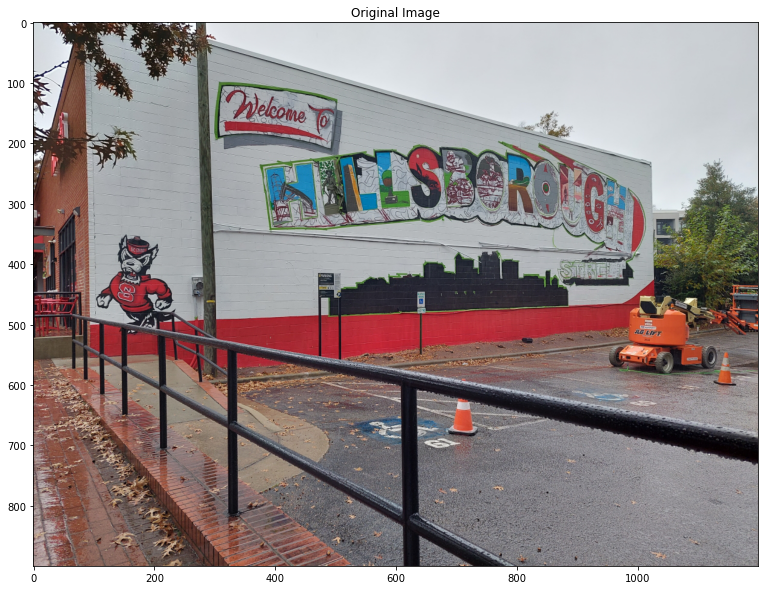

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('G:/Test_dataset/HR/0010.jpg')) # 'G:/Test_dataset/HR/018_00000.png'
ax.title.set_text("Original Image")
plt.show()

Then we need to make distorted image by resizing down and up.

(900, 1200, 3)


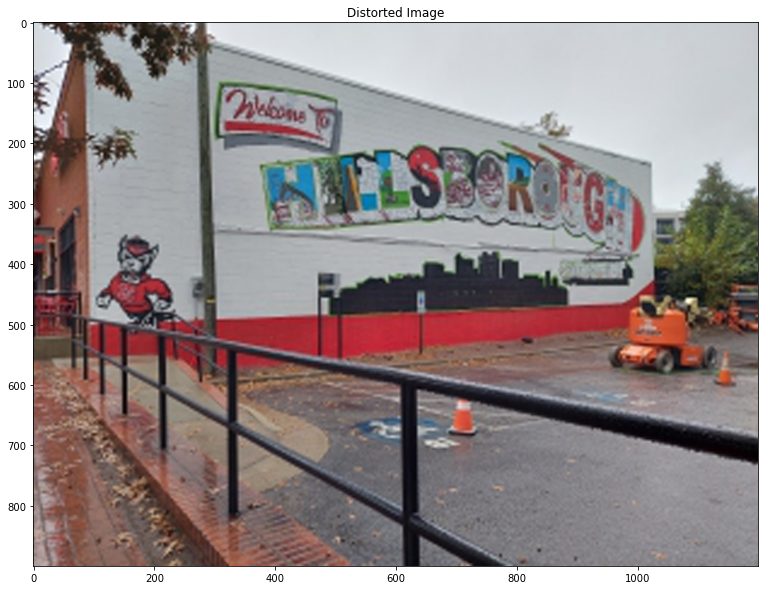

In [29]:
# Make output directory
# try:
#     os.listdir('G:.Test_dataset/LR/downscale_4/output')
# except:
#     os.makedirs('G:.Test_dataset/LR/downscale_4/output')
target = cv2.imread('G:/Test_dataset/HR/0010.jpg', cv2.IMREAD_COLOR) # 'G:/Test_dataset/HR/018_00000.png'
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
target = target[:, :, 0]
shape = target.shape
Y_img = cv2.imread('G:/Test_dataset/LR/downscale_4/0010.jpg', cv2.IMREAD_COLOR) # 'G:/Test_dataset/LR/downscale_4/018_00000.png'
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)
print(Y_img.shape)

cv2.imwrite('G:/Test_dataset/LR/0010_downscale_4.png', Y_img) # 'G:/Test_dataset/LR/018_00000_downscale_4.png'

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('G:/Test_dataset/LR/0010_downscale_4.png')) # 'G:/Test_dataset/LR/018_00000_downscale_4.png'
ax.title.set_text("Distorted Image")
plt.show()

(900, 1200, 3)


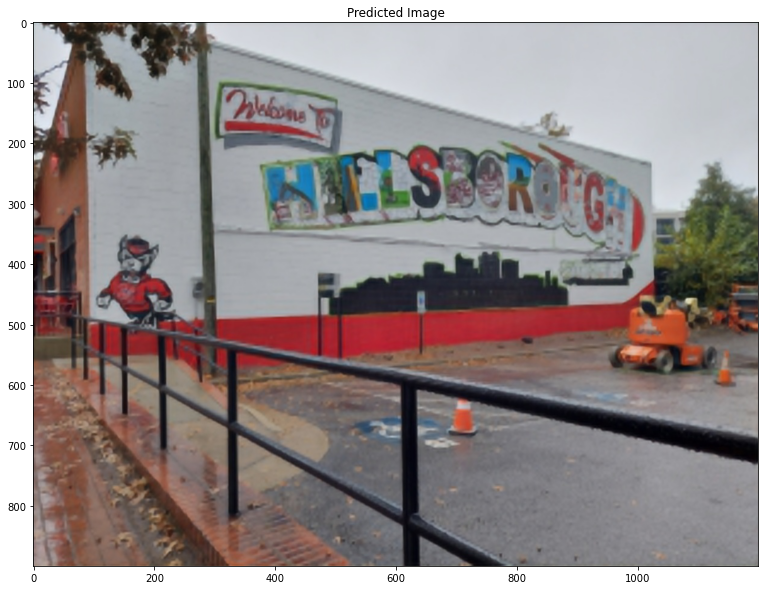

In [30]:
Y = np.zeros((1, Y_img.shape[0], Y_img.shape[1], Y_img.shape[2]), dtype=np.float32)

Y[0, :, :, :] = Y_img.astype(np.float32) /255.

# Predict
srcnn_model.load_weights('G:/srcnn/model_rgb.h5')
pre = srcnn_model.predict(Y, batch_size=1) * 255.
# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)


output = np.copy(pre[0])
print(output.shape)
# Save image
cv2.imwrite('G:/Test_dataset/output/0010.jpg', output) # 'G:/Test_dataset/output/018_00000.png'

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('G:/Test_dataset/output/0010.jpg')) # 'G:/Test_dataset/output/018_00000.png'
ax.title.set_text("Predicted Image")
plt.show()

We can compare those images simultaneously.

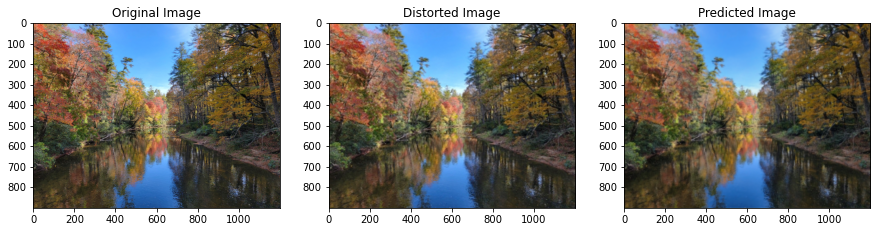

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('G:/Test_dataset/HR/0002,jpg'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('G:/Test_dataset/LR/0002_downscale_4.png'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('G:/Test_dataset/output/0002,jpg'))
ax[2].title.set_text("Predicted Image")

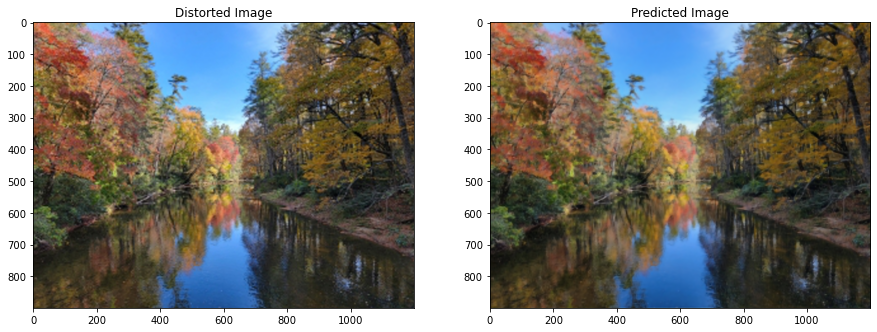

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('G:/Test_dataset/LR/0002_downscale_4.png'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open('G:/Test_dataset/output/0002,jpg'))
ax[1].title.set_text("Predicted Image")

Here, we can use PSNR and SSIM metrics for comparison. Of course, we need to compare each images with original image.

In [17]:
original = cv2.imread('G:/Test_dataset/HR/0002,jpg')
distorted = cv2.imread('G:/Test_dataset/LR/0002_downscale_4.png')
predicted = cv2.imread('G:/Test_dataset/output/0002.png')

In [18]:
# Comparing original and distorted image
metrics = compare_images(distorted, original)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 23.42366923340935
MSE: 886.8183935185185
SSIM: 0.5227297119152338


In [19]:
# Comparing original and predicted image
metrics = compare_images(predicted, original)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 22.929603366155305
MSE: 993.6679425925926
SSIM: 0.4871960159027189


Finally, we calculate the averaged PSNR, MSE and SSIM for the whole test dataset. 

In [22]:
# Calculate AVG Predict result
srcnn_model.load_weights('G:/srcnn/model_rgb.h5')
metrices = []

prediction = srcnn_model.predict(X_test, batch_size = 1) * 255.

print(prediction.shape)
for i in range(len(prediction)):
    pre = prediction[i]
    # Post process output
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    output = pre.astype(np.uint8)
    
    y_test[i] = y_test[i] * 255.
    origin = y_test[i].astype(np.uint8)
    #calculate the metrices       
    metrices.append(compare_images(output, origin))
metrices = np.array(metrices, dtype=np.float32)
print(metrices.shape)

NameError: name 'X_test' is not defined

In [13]:
metrices_avg = np.mean(metrices, axis=0)
print(metrices_avg.shape)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrices_avg[0]))
print("MSE: {}".format(metrices_avg[1]))
print("SSIM: {}".format(metrices_avg[2]))

(3,)
Metrics for original and predicted image
PSNR: 21.78746795654297
MSE: 1443.427490234375
SSIM: 0.6463400721549988


In [36]:
with h5py.File('G:/Test_dataset/test_downscale_4.h5', 'r') as h:
    X_test = np.array(h.get('data'))
    y_test = np.array(h.get('label'))
    
shape = y_test.shape

bicubic_metric = []

for i in range(len(X_test)):
    dis = X_test[i] * 255.
    dis = dis.astype(np.uint8)
    distortion = cv2.resize(dis, (shape[2], shape[1]), interpolation=cv2.INTER_CUBIC)
    origin = y_test[i] * 255.
    origin = origin.astype(np.uint8)
    bicubic_metric.append(compare_images(distortion, origin))
    
bicubic_metric = np.array(bicubic_metric, dtype=np.float32)
bicubic_avg = np.mean(bicubic_metric, axis=0)
print(bicubic_avg.shape)
print("Metrics for original and distorted image")
print("PSNR: {}".format(bicubic_avg[0]))
print("MSE: {}".format(bicubic_avg[1]))
print("SSIM: {}".format(bicubic_avg[2]))

(3,)
Metrics for original and distorted image
PSNR: 21.721128463745117
MSE: 1473.5177001953125
SSIM: 0.646841824054718


## Summary
We can see that Peak Signal to Noise Ratio of predicted image is higher than that of distorted image, and same in Structural Similarity. As a result, it concludes that SR-CNN model can enhance the image quality, and the predicted output is more similar with original image.